In [1]:
import threading
import random
import time
import contextlib
import io
import matplotlib.pyplot as plt
import re
import sys
import numpy as np
import networkx as nx
from dataclasses import dataclass, field

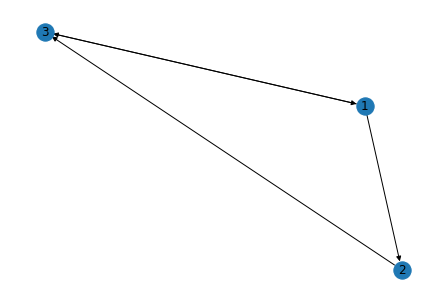

In [4]:
di_graph = nx.DiGraph()

di_graph.add_node(1)
di_graph.add_node(2)
di_graph.add_node(3)

di_graph.add_edge(1, 2)
di_graph.add_edge(2, 3)
di_graph.add_edge(3, 1)
di_graph.add_edge(1, 3)

nx.draw(di_graph, with_labels=True)

plt.show()

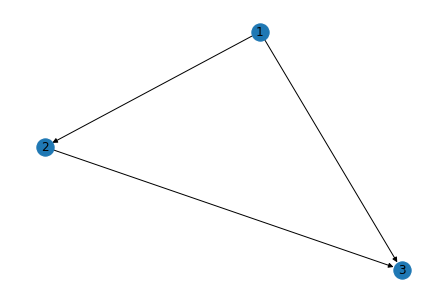

In [5]:
di_graph.remove_edge(3,1)
nx.draw(di_graph, with_labels=True)

plt.show()